In [1]:
import numpy as np

from standard_tester import *

from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
# as chosen in Nguyen 2014
ks = [RBF(name='rbf0')]
ranks = [2]
# all_ixs is union of all xss, holdout, holdin are dictionaries of slices
xss, yss, test_xss, test_yss, fx2007, all_ixs, holdout, holdin = foreign_exchange_2007()
pred_xss = test_xss

In [3]:
num_runs = 3
inducing_points = [20, 40, 100, 200, 250]
runlmc_times, runlmc_smses, runlmc_nlpds = [], [], []
for m in inducing_points:
    time, smse, nlpd, _ = runlmc(
        num_runs, m,
        xss, yss, test_xss, test_yss,
        ks, ranks, {'max_it': 10000, 'verbosity':1})
    print('**************************************')
    print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
    print('**************************************')
    runlmc_times.append(time)
    runlmc_smses.append(smse)
    runlmc_nlpds.append(nlpd)

starting adadelta {'offset': 0.0001, 'roll': 2, 'momentum': 0.5, 'min_grad_ratio': 0.5, 'decay': 0.9, 'max_it': 10000, 'step_rate': 1, 'verbosity': 1}
finished adadelta optimization
            19 iterations
    3.2117e+01 final grad norm
    4.7677e+01 final MA(2) grad norm
    9.8589e+01 max MA(2) grad norm
    norm used inf
starting adadelta {'offset': 0.0001, 'roll': 2, 'momentum': 0.5, 'min_grad_ratio': 0.5, 'decay': 0.9, 'max_it': 10000, 'step_rate': 1, 'verbosity': 1}
finished adadelta optimization
            22 iterations
    6.1911e+01 final grad norm
    6.8204e+01 final MA(2) grad norm
    1.5030e+02 max MA(2) grad norm
    norm used inf
starting adadelta {'offset': 0.0001, 'roll': 2, 'momentum': 0.5, 'min_grad_ratio': 0.5, 'decay': 0.9, 'max_it': 10000, 'step_rate': 1, 'verbosity': 1}
finished adadelta optimization
            21 iterations
    9.3971e+01 final grad norm
    8.9865e+01 final MA(2) grad norm
    2.2367e+02 max MA(2) grad norm
    norm used inf
*************

In [3]:
num_runs = 3
inducing_points = [10, 20, 40, 100, 200, 250]
cogp_times, cogp_smses, cogp_nlpds = [], [], []
for m in inducing_points:
    time, smse, nlpd = cogp_fx2007(num_runs, m)
    print('**************************************')
    print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
    print('**************************************')
    cogp_times.append(time)
    cogp_smses.append(smse)
    cogp_nlpds.append(nlpd)

**************************************
m 10 time 15.824306 smse 0.287032772457891 nlpd 66.33942400098648
**************************************


In [5]:
# for picture: search for best lmc model with fixed num of inducing
_, _, _, best = runlmc(
    5, 200,
    xss, yss, test_xss, test_yss,
    ks, ranks, {'max_it': 10000, 'verbosity':0})

time 22.86928
smes 0.488346712971921
nlpds 94.42110850628997


(753, 1)


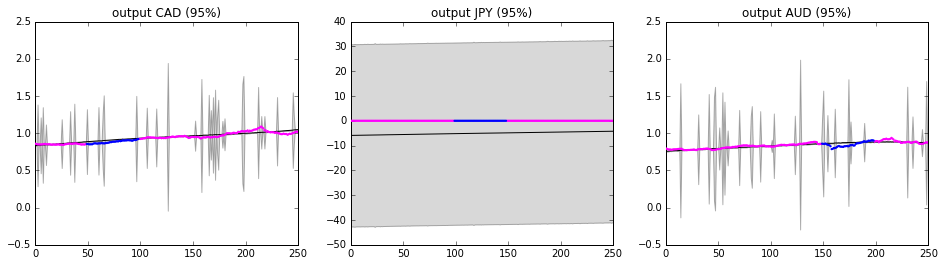

In [8]:
# Prints best lmc model
pred_xss = [all_ixs if col in test_fx else [] for col in fx2007.columns]
pred_yss, pred_vss = best.predict(pred_xss)
pred_xss = {col: xs for col, xs in zip(fx2007.columns, pred_xss)}
pred_yss = {col: ys for col, ys in zip(fx2007.columns, pred_yss)}
pred_vss = {col: vs for col, vs in zip(fx2007.columns, pred_vss)}

_, axs = plt.subplots(ncols=3, figsize=(16, 4))
for col, ax in zip(test_fx, axs):
    
    # Prediction everywhere
    pred_xs = pred_xss[col]
    pred_ys = pred_yss[col]
    sd = np.sqrt(pred_vss[col])
    ax.plot(pred_xs, pred_ys, c='black')
    top = pred_ys + 2 * sd
    bot = pred_ys - 2 * sd
    ax.fill_between(pred_xs, bot, top, facecolor='grey', alpha=0.3)    
    
    # Actual holdout
    marker_size = 5
    test_xs = all_ixs[holdout[col]]
    test_ys = np.reciprocal(fx2007.ix[holdout[col], col].values)
    ax.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11)
    
    # Rest of image
    rest_xs = all_ixs[holdin[col]]
    rest_ys = np.reciprocal(fx2007.ix[holdin[col], col].values)
    ax.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10)
    
    ax.set_xlim([0, 250])
    ax.set_title('output {} (95%)'.format(col))


plt.show()